Model: Linear Regression
Test RMSE: 108.39254196967966
Test R-squared: 0.003293158248679595
Cross-Validation RMSE: 2162.3767735913475
----------------------------------------
Model: Random Forest
Test RMSE: 109.78360282122811
Test R-squared: -0.022453568793528333
Cross-Validation RMSE: 2877.666349830145
----------------------------------------
Model: XGBoost
Test RMSE: 111.70637295919106
Test R-squared: -0.058582081307409384
Cross-Validation RMSE: 4720.375215311487
----------------------------------------
Model: Decision Tree
Test RMSE: 95.36360593927006
Test R-squared: 0.22850348992344804
Cross-Validation RMSE: 6903.115575001469
----------------------------------------
Model: Gradient Boosting
Test RMSE: 107.80802658493788
Test R-squared: 0.014013815589403178
Cross-Validation RMSE: 4808.735151232528
----------------------------------------
Model: Support Vector Regression
Test RMSE: 110.12205846019239
Test R-squared: -0.028767601121182818
Cross-Validation RMSE: 2189.864123830603
-----

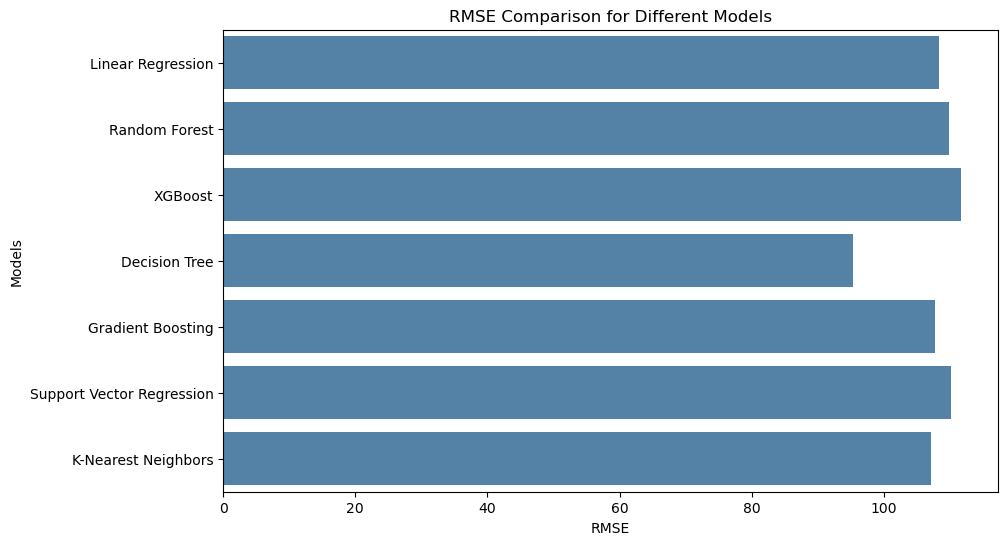

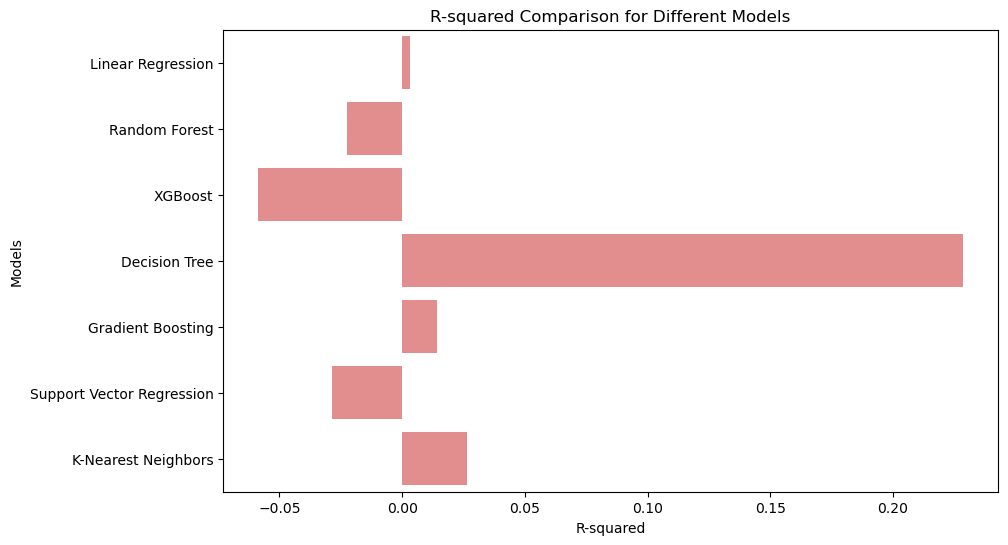

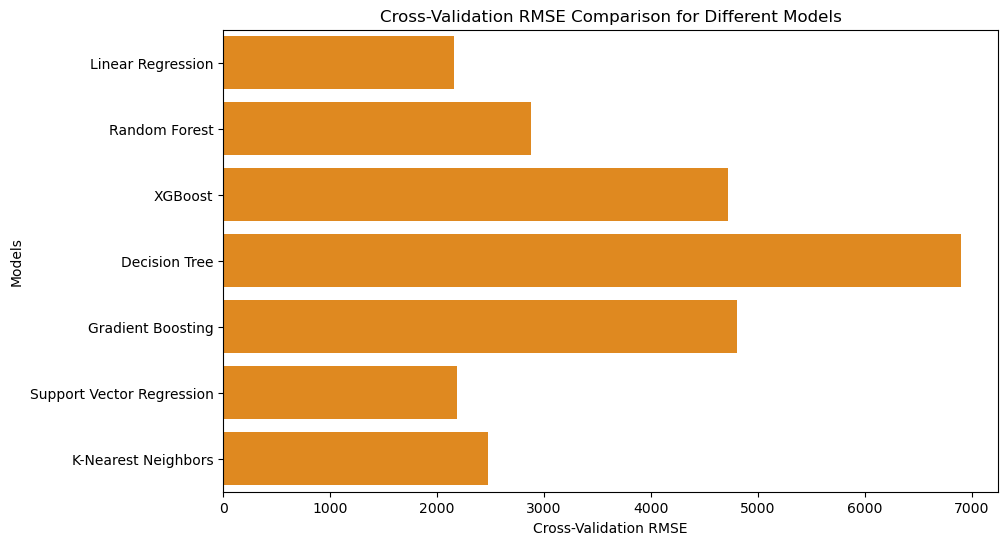

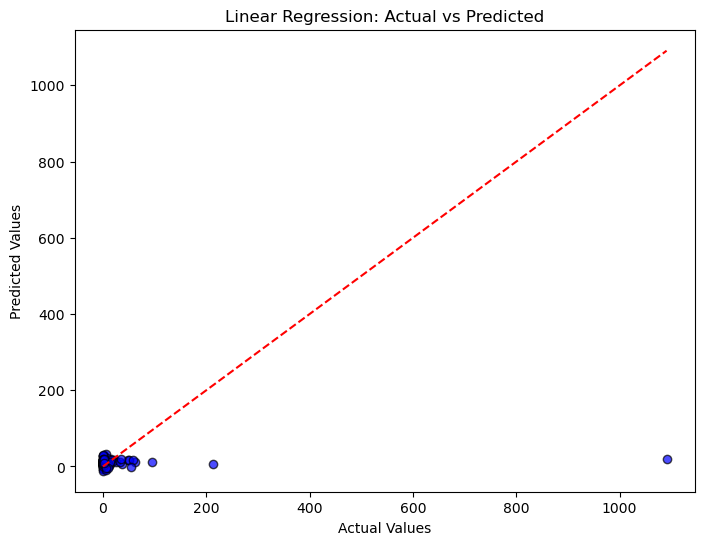

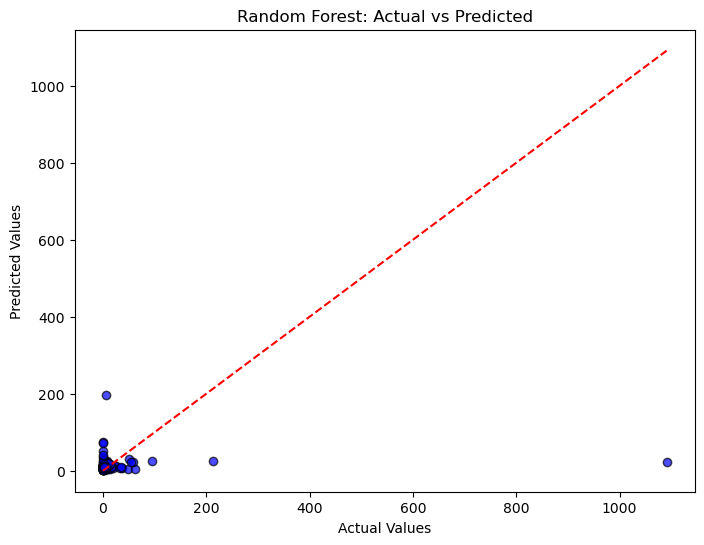

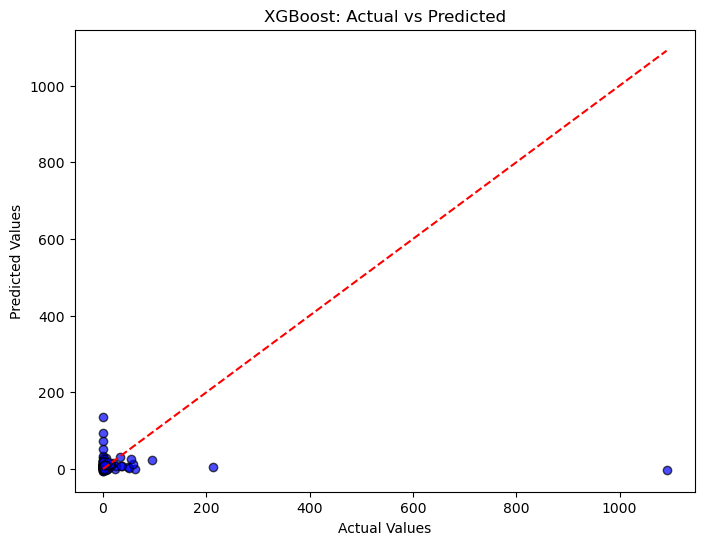

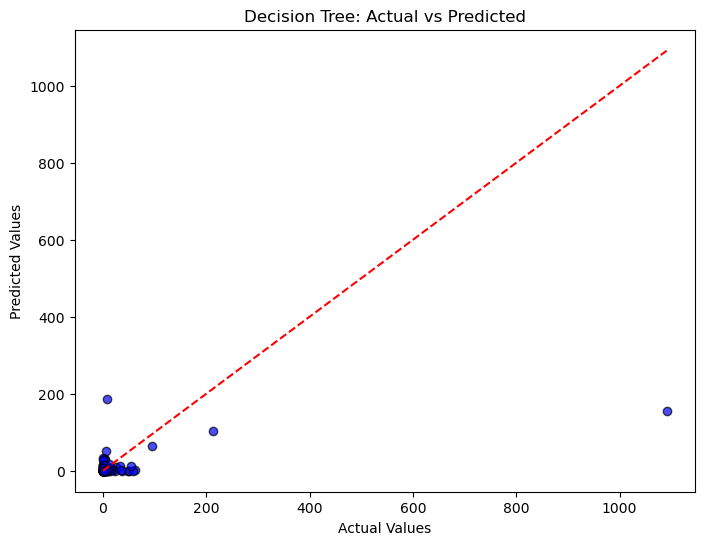

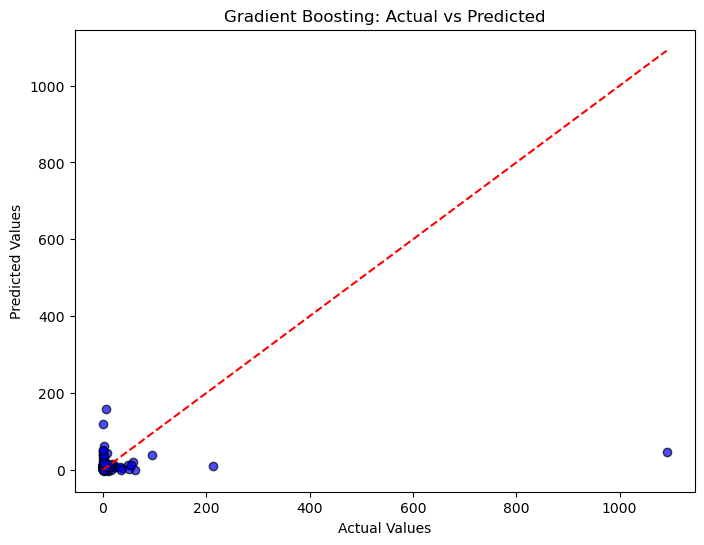

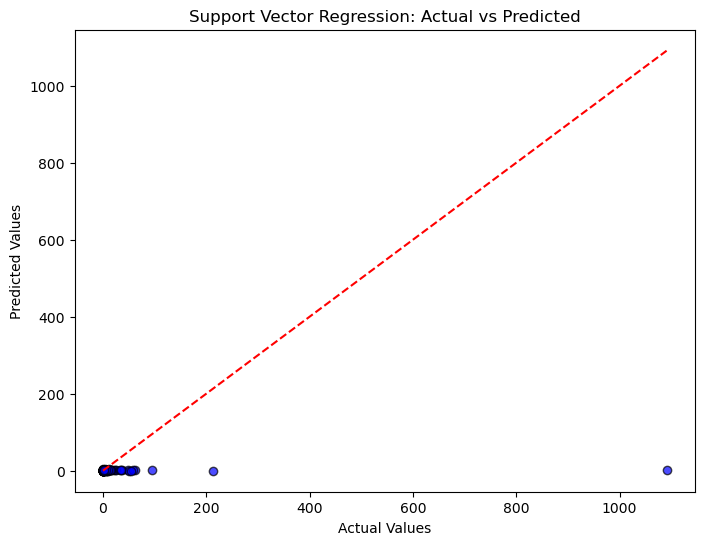

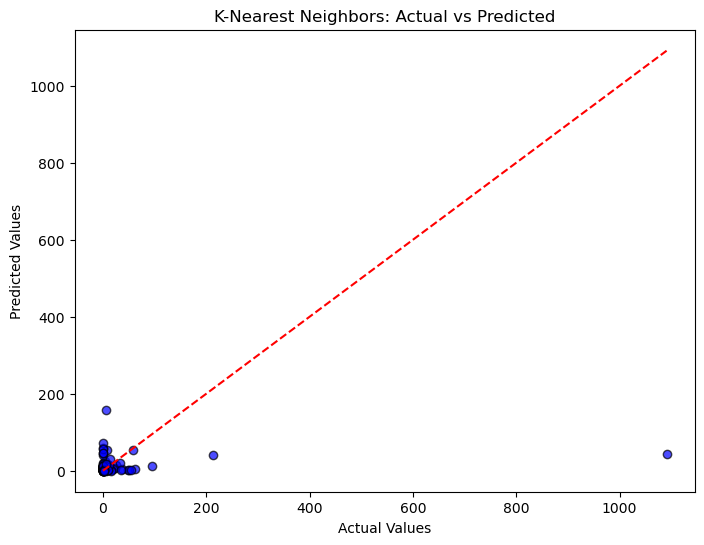

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Fetch dataset
forest_fires = fetch_ucirepo(id=162)

# Data (as pandas dataframes)
X = forest_fires.data.features
y = forest_fires.data.targets

# Convert categorical columns to numeric using LabelEncoder (if necessary)
label_encoder = LabelEncoder()
categorical_columns = X.select_dtypes(include=['object']).columns
for column in categorical_columns:
    X.loc[:, column] = label_encoder.fit_transform(X[column])

# Scaling numerical features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Flatten y into a 1D array (avoiding DataConversionWarning)
y = y.values.ravel()

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# List of models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

# Evaluating each model
results = {}
for model_name, model in models.items():
    # Check if the model supports sample_weight
    if hasattr(model, 'fit') and 'sample_weight' in model.fit.__code__.co_varnames:
        # Pass sample_weight if the model supports it during cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', fit_params={'sample_weight': np.ones_like(y_train)})
    else:
        # Otherwise, just use cross_val_score without sample_weight
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    mean_cv_score = np.mean(np.abs(cv_scores))  # Mean RMSE over folds
    
    # Train model on the entire training set
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate RMSE and R² score
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[model_name] = {"RMSE": rmse, "R-squared": r2, "Predictions": y_pred, "CV-RMSE": mean_cv_score}

# Display results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Test RMSE: {metrics['RMSE']}")
    print(f"Test R-squared: {metrics['R-squared']}")
    print(f"Cross-Validation RMSE: {metrics['CV-RMSE']}")
    print("----------------------------------------")

# Model performance comparison
print("Model Performance Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE = {metrics['RMSE']}, R² = {metrics['R-squared']}, CV-RMSE = {metrics['CV-RMSE']}")

# Plotting RMSE for all models
plt.figure(figsize=(10, 6))
rmse_values = [metrics["RMSE"] for metrics in results.values()]
model_names = list(results.keys())
sns.barplot(x=rmse_values, y=model_names, color="steelblue")
plt.title("RMSE Comparison for Different Models")
plt.xlabel("RMSE")
plt.ylabel("Models")
plt.show()

# Plotting R-squared for all models
plt.figure(figsize=(10, 6))
r2_values = [metrics["R-squared"] for metrics in results.values()]
sns.barplot(x=r2_values, y=model_names, color="lightcoral")
plt.title("R-squared Comparison for Different Models")
plt.xlabel("R-squared")
plt.ylabel("Models")
plt.show()

# Plotting Cross-Validation RMSE for all models
plt.figure(figsize=(10, 6))
cv_rmse_values = [metrics["CV-RMSE"] for metrics in results.values()]
sns.barplot(x=cv_rmse_values, y=model_names, color="darkorange")
plt.title("Cross-Validation RMSE Comparison for Different Models")
plt.xlabel("Cross-Validation RMSE")
plt.ylabel("Models")
plt.show()

# Actual vs Predicted Plots for each model
for model_name, metrics in results.items():
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, metrics["Predictions"], color='blue', edgecolor='k', alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()
